In [4]:
from openpyxl import load_workbook
import re
import pandas as pd
import numpy as np

In [5]:
def extract_number(sheet, i):
    filename = sheet["C" + str(i)].value
    filename.replace(" ", "")
    number_of_dashes = filename.count("-")
    if number_of_dashes == 5 or number_of_dashes == 4:
        number = filename.split("-")[4]
    else:
        number = ""
    return number

In [6]:
def find_number(sheet):
    number_list = []
    for i in range(2, sheet.max_row):
        number = extract_number(sheet, i)
        if len(number) == 6:
            number_list.append(number)
    return number_list

In [7]:
workbook = load_workbook(filename="Lead Monitoring Report  (52).xlsx")
sheet = workbook.active
numbers_list = find_number(sheet)

In [8]:
def vectorize_words(df):
    n_grams = df["n-gram"].tolist()
    unique_n_grams = list(dict.fromkeys(n_grams))
    return unique_n_grams

In [9]:
def organize_words(df):
    words_per_file = dict()
    for i in range(1, 186):
        n_grams = df["n-gram"][df.filecount == i].tolist()
        frequencies = df["frequency"][df.filecount == i].tolist()
        filenames = df["filename"][df.filecount == i].tolist()
        number = filenames[0].split("-")[4][0:6]
        words_per_file[number] = [(n_grams[j], frequencies[j]) for j in range(len(n_grams))]
    return words_per_file

In [10]:
df = pd.read_csv("output.csv")
words_list = vectorize_words(df)
words_and_frequencies = organize_words(df)

In [11]:
common_files = list(set(numbers_list).intersection(words_and_frequencies.keys()))
words_dict = {}
for file_number in words_and_frequencies.keys():
    if file_number in common_files:
        words_dict[file_number] = words_and_frequencies[file_number]

In [12]:
def vectorize_names(sheet, column, numbers_list):
    big_name_list = []
    encodings_dict = dict()
    for i in range(2, sheet.max_row):
        names = sheet[column + str(i)].value
        names = names.replace(",", ", ")
        names = names.split("/")[1]
        x = re.findall("\d+", names)
        if (x):
            total = re.split('\d+', names)[1]
        else:
            continue
        total = total.replace(") ", "")
        name_list = total.split(", ")
        name_list = [name.lower() for name in name_list]
        name_list = [name.lstrip() for name in name_list]
        file_number = extract_number(sheet, i)
        if file_number in numbers_list:
            big_name_list += name_list
            encodings_dict[file_number] = name_list
        
    final_list = list(dict.fromkeys(big_name_list))
    final_list = sorted(final_list)
    return final_list[1:], encodings_dict

In [13]:
def hot_encode_numbers(lst, dct):
    for key in dct.keys():
        dct[key] = [1 if i in dct[key] else 0 for i in lst]

In [14]:
R_list, R_dict = vectorize_names(sheet, "Q", common_files)
LR_list, LR_dict = vectorize_names(sheet, "R", common_files)
OLR_list, OLR_dict = vectorize_names(sheet, "S", common_files)

hot_encode_numbers(R_list, R_dict)
hot_encode_numbers(LR_list, LR_dict)
hot_encode_numbers(OLR_list, OLR_dict)

In [17]:
def hot_encode_words(words_list, words_per_file):
    encoding = dict()
    i=1
    for number in words_per_file.keys():
        for pair in words_per_file[number]:
            if number not in encoding.keys():
                encoding[number] = np.zeros(len(words_list))
            encoding[number][words_list.index(pair[0])] = pair[1]
        print(i)
        i+=1
    return encoding

In [ ]:
words_encoding = hot_encode_words(words_list, words_dict)

In [21]:
def match_encodings(numbers_encoding, words_encoding):
    X = []
    Y = []
    for n1 in numbers_encoding.keys():
        for n2 in words_encoding.keys():
            if n1 == n2:
                X.append(words_encoding[n2])
                Y.append(numbers_encoding[n1])
    return X, Y

In [22]:
X, Y = match_encodings(R_dict, words_encoding)

In [24]:
import pickle
with open("data.pickle", 'wb') as f:
    pickle.dump([X, Y], f)

In [25]:
import pickle
from sklearn.model_selection import train_test_split
with open('data.pickle', 'rb') as f:
    X, Y = pickle.load(f)

df_X = pd.DataFrame(X)
dfY = pd.DataFrame(Y)

In [26]:
to_be_deleted = []
for i in range(dfY.shape[1]):
    count = 0
    for y in Y:
        count += y[i]
    if count < 10:
        to_be_deleted.append(i)
        
df_Y = dfY.drop(to_be_deleted, axis=1)
df_Y.columns = range(df_Y.shape[1])

In [27]:
names_list = pd.DataFrame(R_list)
names_list = names_list.drop(to_be_deleted).reset_index(drop=True)

In [28]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
from random import sample
%matplotlib inline

from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

no_of_people = df_Y.shape[1]
X_train, X_test = [[] for i in range(no_of_people)], [[] for i in range(no_of_people)]
Y_train, Y_test = [[] for i in range(no_of_people)], [[] for i in range(no_of_people)]
total = df_Y.shape[0]
test_portion = round(total * 0.3)
for i in range(no_of_people):
    k = 0
    for j in range(total):
        if df_Y.iloc[j][i] == 1 or total - j <= test_portion - k:
            Y_test[i].append(df_Y.iloc[j].tolist()[i])
            X_test[i].append(df_X.iloc[j])
            k += 1
        else:
            Y_train[i].append(df_Y.iloc[j])
            X_train[i].append(df_X.iloc[j])
        if k == 3:
            indices = np.arange(j + 1, df_Y.shape[0])
            test_indices = sample(list(indices), test_portion - 3)
            for z in range(j + 1, df_Y.shape[0]):
                if z in test_indices:
                    Y_test[i].append(df_Y.iloc[z].tolist()[i])
                    X_test[i].append(df_X.iloc[z])
                else:
                    Y_train[i].append(df_Y.iloc[z])
                    X_train[i].append(df_X.iloc[z])
            break

In [29]:
Y_pred = []
models = {}
for i in range(no_of_people):
    x_train = X_train[i]
    y_train = [y[i] for y in Y_train[i]]
    if sum(y_train) == 0:
        Y_pred.append(np.array([0 for y in range(26)]))
        print("noooo")
        continue
    models[i] = sgd.fit(x_train, y_train)
    y_pred = models[i].predict(X_test[i])
    Y_pred.append(y_pred)

In [32]:
Y_pred_transposed = [*zip(*Y_pred)]
Y_test_transposed = [*zip(*Y_test)]

In [33]:
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
Y_pred_list = [p.tolist() for p in Y_pred]
print('accuracy %s' % accuracy_score(Y_pred_transposed, Y_test_transposed))
print(classification_report(Y_test_transposed, Y_pred_transposed))
precision, recall, fscore, support = precision_recall_fscore_support(Y_test_transposed, Y_pred_transposed)

accuracy 0.0
              precision    recall  f1-score   support

           0       0.70      0.54      0.61        13
           1       0.88      1.00      0.94        22
           2       0.80      1.00      0.89        20
           3       0.91      0.77      0.83        13
           4       0.88      1.00      0.94        22
           5       0.71      0.62      0.67        16
           6       0.73      0.58      0.65        19
           7       0.56      0.45      0.50        11
           8       0.71      0.77      0.74        13
           9       0.62      0.42      0.50        12
          10       1.00      0.36      0.53        11
          11       0.75      0.33      0.46         9
          12       1.00      0.18      0.31        11
          13       0.62      0.50      0.56        10
          14       0.84      0.80      0.82        20
          15       0.96      1.00      0.98        24
          16       0.92      1.00      0.96        23
          17  

C:\Users\efeha\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [34]:
from tabulate import tabulate

data = [names_list[0].tolist(), precision, recall, fscore, support]
transpose = np.transpose(data)
final = sorted(transpose, key=lambda x: int(x[4]), reverse=True)
table = tabulate(final, headers = ["name", "precision", "recall", "f1-score", "support"], tablefmt="fancy_grid")
print(table)

╒════════════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ name                   │   precision │   recall │   f1-score │   support │
╞════════════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ eda teki̇roğlu          │    0.96     │ 1        │   0.979592 │        24 │
├────────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ evren eki̇nci̇           │    0.958333 │ 0.958333 │   0.958333 │        24 │
├────────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ekin eki̇z              │    0.92     │ 1        │   0.958333 │        23 │
├────────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ mehmet emin karaaslan  │    0.913043 │ 0.913043 │   0.913043 │        23 │
├────────────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ ahmet ergin efendi̇oğlu │    0.88     │ 1        │   0.93617  │        22 │
├────────────────────────┼─────────────┼──────────┼────────────┼───────

In [37]:
df_data = pd.DataFrame(transpose)
precision = {}
recall = {}
f1 = {}

for i in range(25, 3, -1):
    prec = df_data[support == i][1]
    rec = df_data[support == i][2]
    f = df_data[support == i][3]
    if len(prec) != 0:
        average_prec = sum([float(p) for p in prec]) / len(prec)
        precision[i] = average_prec
        
        average_rec = sum([float(p) for p in rec]) / len(rec)
        recall[i] = average_rec
        
        average_f = sum([float(p) for p in f]) / len(f)
        f1[i] = average_f

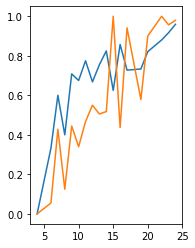

In [41]:
import seaborn

x_pre = np.array(list(precision.keys()))
y_pre = np.array(list(precision.values()))

x_rec = np.array(list(recall.keys()))
y_rec = np.array(list(recall.values()))

plt.subplot(1, 2, 2)
plt.plot(x_pre,y_pre)
plt.plot(x_rec,y_rec)